# ==========================================
# 1. Imports & Configuration
# ==========================================

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Configuration for Academic Visualizations ---

In [172]:

# Set plot style to 'whitegrid' for better readability
sns.set_style("whitegrid")
# Set context to 'paper' for appropriate font scaling in reports
sns.set_context("paper", font_scale=1.4)

# Ensure pandas displays all columns
pd.set_option('display.max_columns', None)

# --- Path Configuration ---

In [173]:
RAW_DATA_PATH = '../data/raw'
PROCESSED_DATA_PATH = '../data/processed'
FIGURES_PATH = '../results/figures'

# Ensure output directories exist
os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)
os.makedirs(FIGURES_PATH, exist_ok=True)

def save_plot(filename):
    """
    Saves the current plot to the figures directory with high DPI.
    Ensures the directory exists before saving.
    """
    file_path = os.path.join(FIGURES_PATH, f"{filename}.png")
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    print(f"[+] Plot saved successfully: {file_path}")

# ==========================================
# 2. Define Column Names (NSL-KDD specific)
# ==========================================

# The NSL-KDD dataset typically lacks headers. 
# These column names correspond to the official documentation.

In [174]:

COLUMNS = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
    'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
    'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
    'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
    'dst_host_srv_count', 'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate', 'label', 'difficulty'
]

# ==========================================
# 3. Data Loading
# ==========================================


In [175]:
train_path = os.path.join(RAW_DATA_PATH, 'KDDTrain+.txt')
test_path = os.path.join(RAW_DATA_PATH, 'KDDTest+.txt')

print(f"Loading datasets from: {RAW_DATA_PATH}...")

try:
    train_df = pd.read_csv(train_path, names=COLUMNS)
    test_df = pd.read_csv(test_path, names=COLUMNS)
    print("Data loaded successfully.")
    print(f"Train set dimensions: {train_df.shape}")
    print(f"Test set dimensions:  {test_df.shape}")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print(f"Please ensure the data files exist in '{RAW_DATA_PATH}'.")

Loading datasets from: ../data/raw...
Data loaded successfully.
Train set dimensions: (125973, 43)
Test set dimensions:  (22544, 43)


# ==========================================
# 4. Data Cleaning & Integrity Checks
# ==========================================

# --- 4.1 Missing Values Analysis ---

In [176]:
print("\n[1] Analyzing Missing Values...")
train_nulls = train_df.isnull().sum().sum()
test_nulls = test_df.isnull().sum().sum()
print(f"Total nulls in Train Set: {train_nulls}")
print(f"Total nulls in Test Set:  {test_nulls}")


[1] Analyzing Missing Values...
Total nulls in Train Set: 0
Total nulls in Test Set:  0


# --- 4.2 Duplicate Removal ---

In [177]:
print("\n[2] Analyzing Duplicates...")
dups_train = train_df.duplicated().sum()
print(f"Duplicates found in Train Set: {dups_train}")

if dups_train > 0:
    train_df.drop_duplicates(inplace=True)
    print(f"Duplicates removed. New Train shape: {train_df.shape}")
else:
    print("No duplicates to remove.")

# Also clean Test set for consistency
dups_test = test_df.duplicated().sum()
if dups_test > 0:
    test_df.drop_duplicates(inplace=True)
    print(f"Duplicates removed from Test Set: {dups_test}")


[2] Analyzing Duplicates...
Duplicates found in Train Set: 0
No duplicates to remove.


# --- 4.3 Feature Selection (Dropping Metadata) ---

# The 'difficulty' column is metadata used for evaluating learners, not for training.

In [178]:
if 'difficulty' in train_df.columns:
    train_df.drop('difficulty', axis=1, inplace=True)
    test_df.drop('difficulty', axis=1, inplace=True)
    print("\n[3] Dropped 'difficulty' metadata column.")


[3] Dropped 'difficulty' metadata column.


# ==========================================
# 5. Exploratory Data Analysis (EDA)
# ==========================================


# Create a binary label for visualization purposes (Normal vs Attack)

In [179]:
train_df['binary_label'] = train_df['label'].apply(lambda x: 'Normal' if x == 'normal' else 'Attack')

# --- 5.1 Class Distribution (Target Variable) ---


[4] Visualizing Class Distribution...
[+] Plot saved successfully: ../results/figures\class_distribution.png


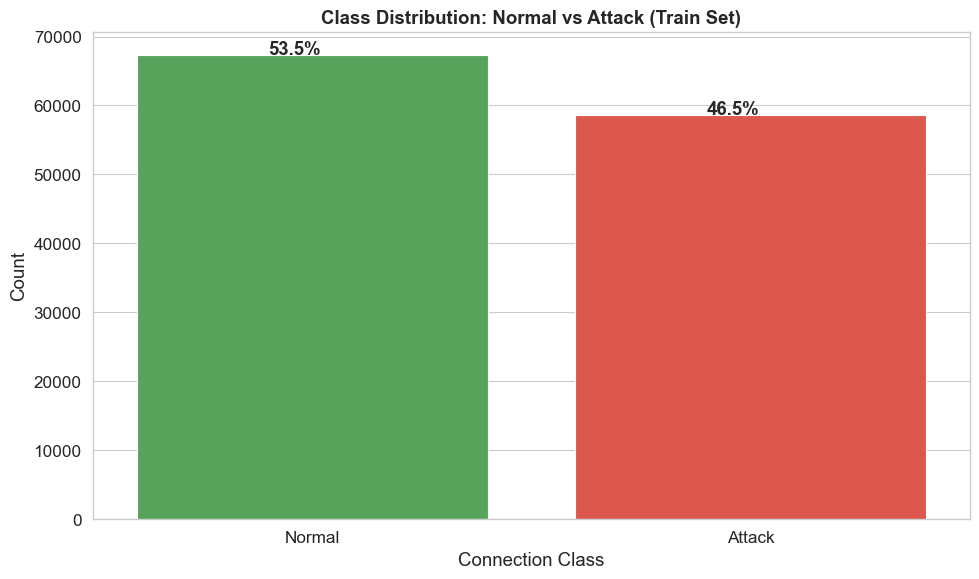

In [180]:
print("\n[4] Visualizing Class Distribution...")
plt.figure(figsize=(10, 6))
palette = {'Normal': '#4CAF50', 'Attack': '#F44336'}

ax = sns.countplot(
    data=train_df,
    x='binary_label',
    hue='binary_label',
    palette=palette,
    legend=False
)

plt.title('Class Distribution: Normal vs Attack (Train Set)', fontweight='bold')
plt.xlabel('Connection Class')
plt.ylabel('Count')

# Add percentage annotations
total = len(train_df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_height() + 150
    ax.annotate(percentage, (x, y), weight='bold')

save_plot('class_distribution')
plt.tight_layout()
plt.show()


# --- 5.2 Protocol Type Distribution ---


[5] Visualizing Protocol Types by Class...
[+] Plot saved successfully: ../results/figures\protocol_distribution.png


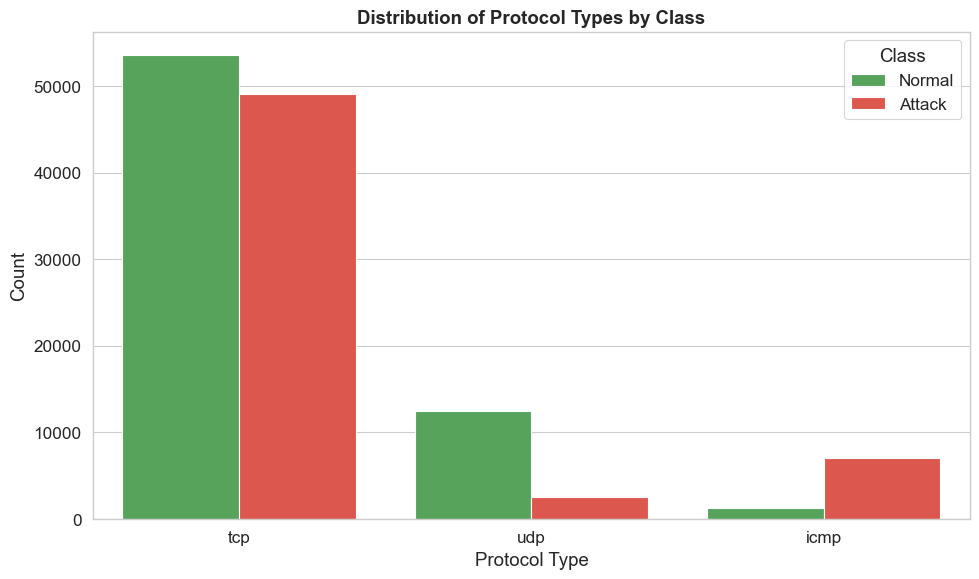

In [181]:
print("\n[5] Visualizing Protocol Types by Class...")
plt.figure(figsize=(10, 6))
sns.countplot(x='protocol_type', hue='binary_label', data=train_df, palette=palette)
plt.title('Distribution of Protocol Types by Class', fontweight='bold')
plt.xlabel('Protocol Type')
plt.ylabel('Count')
plt.legend(title='Class')
save_plot('protocol_distribution')
plt.tight_layout()
plt.show()

# --- 5.3 Correlation Analysis (Heatmap) ---


[6] generating Correlation Matrix...
Top positively correlated with Attack:


binary_target               1.000000
dst_host_srv_serror_rate    0.654985
dst_host_serror_rate        0.651842
serror_rate                 0.650652
srv_serror_rate             0.648289
count                       0.576444
dst_host_count              0.375052
srv_rerror_rate             0.253504
dst_host_srv_rerror_rate    0.253430
rerror_rate                 0.253397
Name: binary_target, dtype: float64

Top negatively correlated with Attack:


num_file_creations       -0.021271
su_attempted             -0.022448
num_access_files         -0.036701
is_guest_login           -0.039279
srv_diff_host_rate       -0.119377
logged_in                -0.690171
dst_host_same_srv_rate   -0.693803
dst_host_srv_count       -0.722535
same_srv_rate            -0.751913
num_outbound_cmds              NaN
Name: binary_target, dtype: float64

[+] Plot saved successfully: ../results/figures\correlation_matrix.png


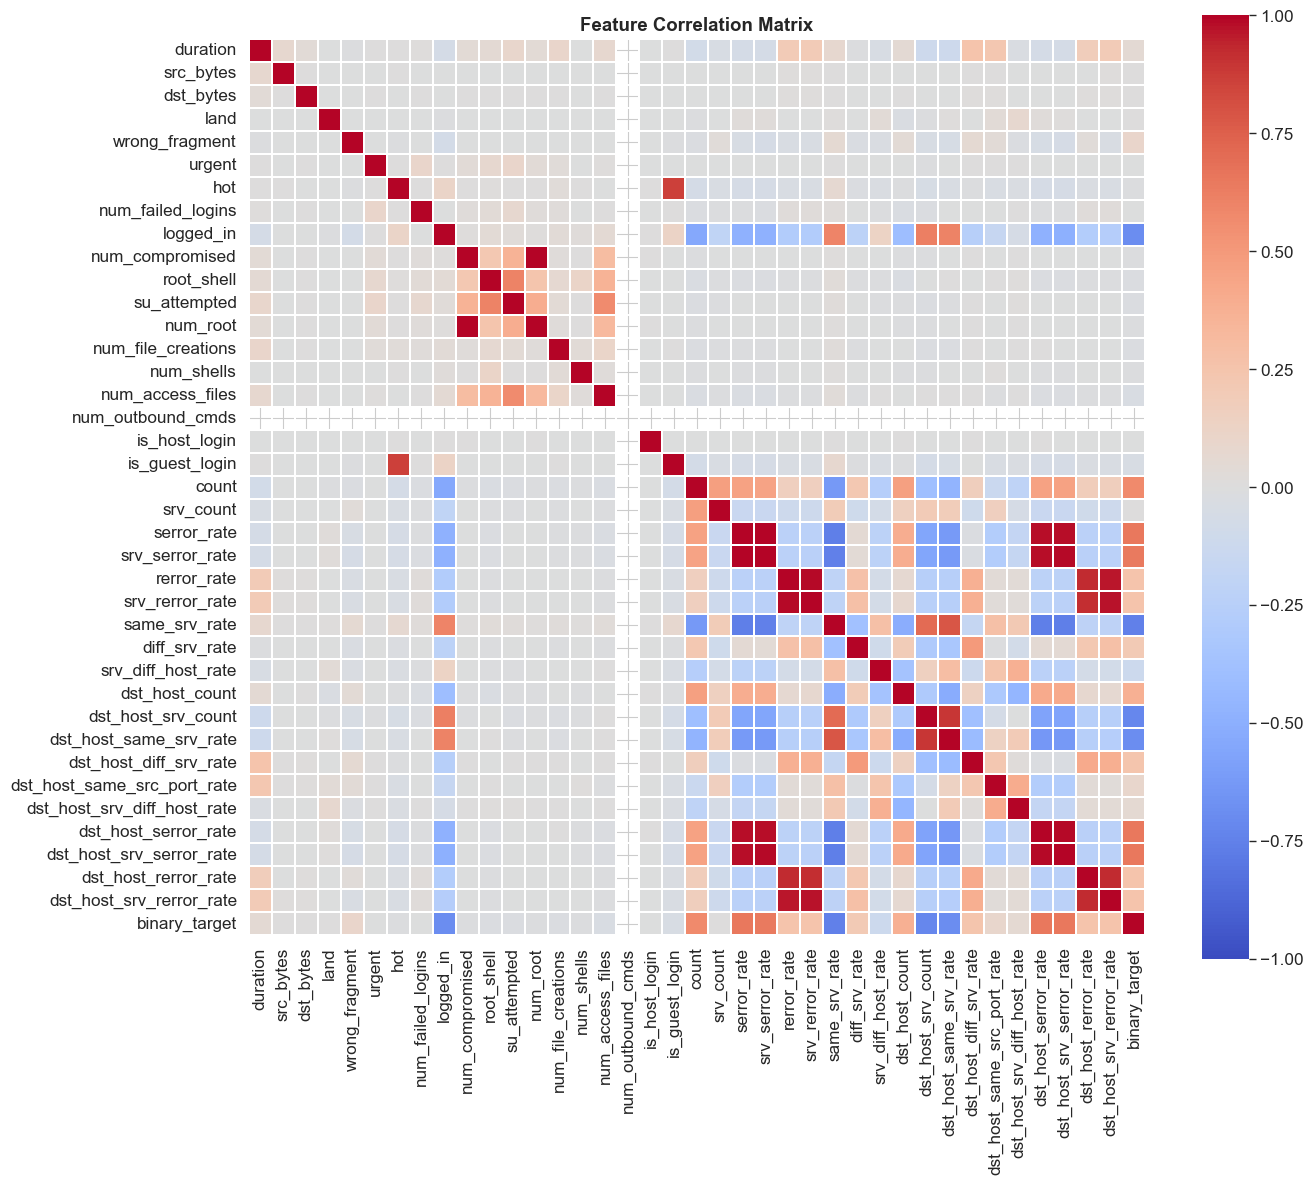

In [182]:
print("\n[6] generating Correlation Matrix...")
plt.figure(figsize=(14, 12))

train_df['binary_target'] = (train_df['label'] != 'normal').astype(int)

# Encode non-numeric features temporarily for correlation
numeric_df = train_df.select_dtypes(include=[np.number])
corr_with_target = numeric_df.corr()['binary_target'].sort_values(ascending=False)

print("Top positively correlated with Attack:")
display(corr_with_target.head(10))

print("Top negatively correlated with Attack:")
display(corr_with_target.tail(10))

# Calculate correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
sns.heatmap(
    corr_matrix, 
    cmap='coolwarm', 
    vmax=1.0, 
    vmin=-1.0, 
    linewidths=0.1,
    annot=False, # Too cluttered with annotations for 40 features
    square=True
)
plt.title('Feature Correlation Matrix', fontweight='bold')
save_plot('correlation_matrix')
plt.tight_layout()
plt.show()

# --- 5.4 Distribution of Key Features (Boxplots) ---


[7] Visualizing Key Feature Distributions...
[+] Plot saved successfully: ../results/figures\key_features_boxplots.png


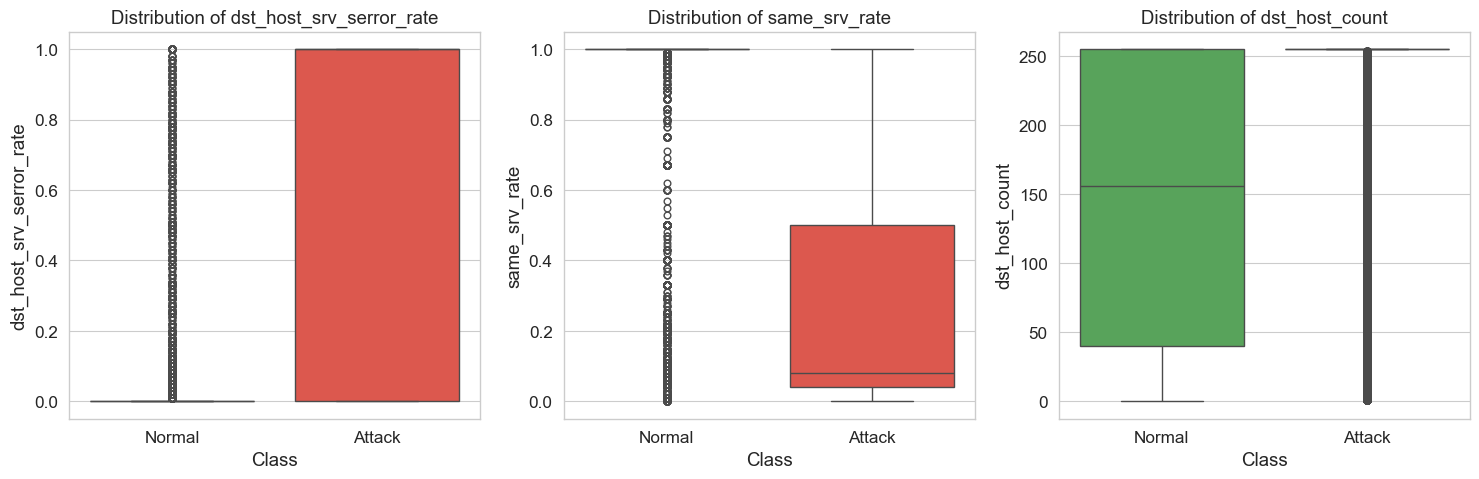

In [ ]:
key_features = ['dst_host_srv_serror_rate', 'same_srv_rate', 'dst_host_count']

print("\n[7] Visualizing Key Feature Distributions...")
plt.figure(figsize=(15, 5))
for i, col in enumerate(key_features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(
        data=train_df,
        x='binary_label',
        y=col,
        hue='binary_label',
        palette=palette,
        dodge=False,
        legend=False
    )
    plt.title(f'Distribution of {col}')
    plt.xlabel('Class')

plt.tight_layout()
save_plot('key_features_boxplots')
plt.tight_layout()
plt.show()



# ==========================================
# 6. Save Processed Data
# ==========================================

In [184]:
print(f"\n[8] Saving cleaned datasets to '{PROCESSED_DATA_PATH}'...")
train_df.to_csv(os.path.join(PROCESSED_DATA_PATH, 'train_cleaned.csv'), index=False)
test_df.to_csv(os.path.join(PROCESSED_DATA_PATH, 'test_cleaned.csv'), index=False)
print("Done. Files saved successfully.")


[8] Saving cleaned datasets to '../data/processed'...
Done. Files saved successfully.
